In [1]:
!pip install catboost
!pip install tsfresh
!pip install xgboost
!pip install shap

    100% |████████████████████████████████| 55.5MB 768kB/s 


    100% |████████████████████████████████| 122kB 4.7MB/s 
    100% |████████████████████████████████| 225kB 9.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/bf/26/bd/912db1314f1cef0171d9b7f128dd01e8b8c92ed8d0062e632d
Successfully built shap


In [2]:
# The essentials
import pandas as pd
import numpy as np

from collections import defaultdict

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Progress bars
from tqdm import tqdm

# Access our Google Drive
from google.colab import drive

# Gradient Boosting
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier

# TSFRESH Feature Extraction
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table

from sklearn.model_selection import KFold, GridSearchCV

from collections import defaultdict, Counter
from scipy.stats import norm

from sklearn.preprocessing import PowerTransformer, StandardScaler

import shap

from hyperopt import hp, tpe
from hyperopt.fmin import fmin

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
drive.mount('/content/drive', force_remount=True)
!ls "/content/drive/My Drive/Rinse Over Run"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
20178.png
20451.png
20899.png
22112.png
22369.png
22414.png
22487.png
23011.png
23142.png
23599.png
23872.png
24804.png
24845.png
24872.png
25129.png
25908.png
25983.png
26270.png
27115.png
27243.png
27346.png
27366.png
27418.png
27508.png
all_train_preds_per_phase.p
baseline_features_with_preds_per_phase.csv
baseline_model_per_nunique_phases.csv
better_prev_object_id_per_10.csv
dtw_distances_3.p
extended_phase_predictors.csv
final_phase_labels_15_14.csv
final

In [0]:
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

def fit_stack(clf, name, X_train, y_train, X_test, n_splits=5):  
  train_predictions = np.zeros((len(X_train),))
  test_predictions = np.zeros((len(X_test), n_splits))
  kf = KFold(n_splits=n_splits, shuffle=True)
  for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    X_cv_train = X_train.iloc[train_idx, :]
    X_cv_test = X_train.iloc[test_idx, :]
    y_cv_train = y_train.iloc[train_idx]
    y_cv_test = y_train.iloc[test_idx]
    
    clf_clone = clone(clf)
    clf_clone.fit(X_cv_train, y_cv_train)
    
    print('[{}] Fold #{} MAPE={}'.format(name, fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(clf_clone.predict(X_cv_test)))))
    
    train_predictions[test_idx] = np.minimum(np.max(y_cv_train), np.maximum(0, clf_clone.predict(X_cv_test)))
    test_predictions[:, fold_ix] = np.minimum(np.max(y_cv_train), np.maximum(0, clf_clone.predict(X_test)))
    
  train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_pred'.format(name)])
  
  # Taking min instead of mean, since undershooting is better than overshooting for MAPE
  # TODO: This changed to mean for now
  test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_pred'.format(name)])
    
  return train_predictions_df, test_predictions_df

def get_corr_features(X):
  row_idx, col_idx = np.where(X.corr() == 1)
  self_corr = set([(i, i) for i in range(X.shape[1])])
  return set(list(zip(row_idx, col_idx))) - self_corr 

def get_uncorr_features(data):
  X_train_corr = data.copy()
  correlated_features = get_corr_features(X_train_corr)
  
  corr_cols = set()
  for row_idx, col_idx in correlated_features:
    corr_cols.add(row_idx)
    corr_cols.add(col_idx)
  
  uncorr_cols = list(set(X_train_corr.columns) - set(X_train_corr.columns[list(corr_cols)]))
   
  col_mask = [False]*X_train_corr.shape[1]
  for col in corr_cols:
    col_mask[col] = True
  X_train_corr = X_train_corr.loc[:, col_mask]
  
  correlated_features = get_corr_features(X_train_corr)
  
  while correlated_features:
    print('{} correlated feature pairs left...'.format(len(correlated_features)))
    corr_row, corr_col = correlated_features.pop()
    col_mask = [True]*X_train_corr.shape[1]
    col_mask[corr_row] = False
    X_train_corr = X_train_corr.loc[:, col_mask]
    correlated_features = get_corr_features(X_train_corr)
  return list(set(list(X_train_corr.columns) + uncorr_cols))

def remove_features(data, target, p_val=0.25):
  single_cols = list(data.columns[data.nunique() == 1])
  
  uncorr_cols = get_uncorr_features(data)
  corr_cols = list(set(data.columns) - set(uncorr_cols))
  
  return list(set(single_cols + corr_cols))

In [0]:
def xgb_mape_eval(preds, dtrain):
    labels = dtrain.get_label()
    return 'mape', np.mean(np.abs((np.exp(labels) - np.exp(preds)) / np.maximum(290000, np.exp(labels))))


def xgb_quantile_obj(preds, labels, quantile=0.25):
    """
    Computes first-order derivative of quantile
    regression loss and a non-degenerate
    substitute for second-order derivative.
    Substitute is returned instead of zeros,
    because XGBoost requires non-zero
    second-order derivatives. See this page:
    https://github.com/dmlc/xgboost/issues/1825
    to see why it is possible to use this trick.
    However, be sure that hyperparameter named
    `max_delta_step` is small enough to satisfy:
    ```0.5 * max_delta_step <=
       min(quantile, 1 - quantile)```.
    @type preds: numpy.ndarray
    @type dmatrix: xgboost.DMatrix
    @type quantile: float
    @rtype: tuple(numpy.ndarray)
    """
    try:
        assert 0 <= quantile <= 1
    except AssertionError:
        raise ValueError("Quantile value must be float between 0 and 1.")

    labels = np.array(labels)
    preds = np.array(preds)
    errors = preds - labels

    left_mask = errors < 0
    right_mask = errors > 0

    grad = quantile * left_mask - (1 - quantile) * right_mask
    hess = np.ones_like(preds)

    return grad, hess
  
def custom_mape(approxes, targets):
    return np.mean(np.abs(np.subtract(approxes, targets)) / np.maximum(np.abs(targets), 290000))

class MAPEMetric(object):
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, targets, weight):
        return custom_mape(np.exp(approxes), np.exp(targets)), len(targets)

In [27]:
combinations_per_recipe = {
    3: [2, 3, 1], 
    9: [8],
    15: [15, 1, 3, 7]
}

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15, 9, 3]:
  for process_combination in combinations_per_recipe[recipe]:
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    
    X_train = train_features.drop('target', axis=1)
#     y_train = np.log(train_features['target']).astype(int)
    y_train = np.minimum(6, np.maximum(2, np.log(np.maximum(0, labels.loc[X_train.index]['return_turbidity_sum']) + 1).astype(int)))
    
    X_test = test_features
    
    to_drop = remove_features(X_train, y_train)
    print(len(to_drop), to_drop)

    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)
    
    N_SPLITS = 10
    train_predictions = np.zeros((len(X_train),))
    test_predictions = np.zeros((len(X_test), N_SPLITS))
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
      X_cv_train = X_train.iloc[train_idx, :]
      X_cv_test = X_train.iloc[test_idx, :]
      y_cv_train = y_train.iloc[train_idx]
      y_cv_test = y_train.iloc[test_idx]
            
      train_idx = np.random.choice(X_cv_train.index, replace=False, size=int(0.9 * len(X_cv_train)))
      val_idx = list(set(X_cv_train.index) - set(train_idx))

      X_cv_val = X_cv_train.loc[val_idx, :]
      y_cv_val = y_cv_train.loc[val_idx]
      X_cv_train = X_cv_train.loc[train_idx, :]
      y_cv_train = y_cv_train.loc[train_idx]

        
      xgb = CatBoostClassifier(n_estimators=100000, learning_rate=0.2, loss_function='MultiClass', task_type='GPU')
      xgb.fit(X_cv_train.values, y_cv_train.values, eval_set=[(X_cv_val.values, y_cv_val.values)], early_stopping_rounds=100, verbose=50)

      print('Fold #{} MAPE={}'.format(fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(xgb.predict(X_cv_test.values))[:, 0])))

      train_predictions[test_idx] = np.minimum(np.max(y_cv_train), np.maximum(0, xgb.predict(X_cv_test.values)[:, 0]))
      test_predictions[:, fold_ix] = np.minimum(np.max(y_cv_train), np.maximum(0, xgb.predict(X_test.values)[:, 0]))

    name = 'cat'
    train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_turbidity_clf_pred'.format(name)])
    test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_turbidity_clf_pred'.format(name)])
    train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_cat_turbidity_clf_{}_{}.csv'.format(recipe, process_combination))
    test_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_cat_turbidity_clf_{}_{}.csv'.format(recipe, process_combination))

958 correlated feature pairs left...
920 correlated feature pairs left...
878 correlated feature pairs left...
842 correlated feature pairs left...
808 correlated feature pairs left...
768 correlated feature pairs left...
736 correlated feature pairs left...
698 correlated feature pairs left...
668 correlated feature pairs left...
632 correlated feature pairs left...
630 correlated feature pairs left...
596 correlated feature pairs left...
568 correlated feature pairs left...
536 correlated feature pairs left...
506 correlated feature pairs left...
480 correlated feature pairs left...
456 correlated feature pairs left...
428 correlated feature pairs left...
402 correlated feature pairs left...
378 correlated feature pairs left...
356 correlated feature pairs left...
336 correlated feature pairs left...
314 correlated feature pairs left...
312 correlated feature pairs left...
292 correlated feature pairs left...
274 correlated feature pairs left...
256 correlated feature pairs left...
2

In [25]:
recipe, Counter( np.log(np.maximum(0, labels.loc[X_train.index]['return_turbidity_sum']) + 1).astype(int))

(15,
 Counter({0: 1,
          1: 59,
          2: 688,
          3: 1551,
          4: 1047,
          5: 242,
          6: 54,
          7: 56,
          8: 25,
          9: 3}))

In [0]:


name = 'xgb'
train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_pred'.format(name)])
test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_pred'.format(name)])
train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_xgb_{}_{}.csv'.format(recipe, process_combination))

In [0]:
combinations_per_recipe = {
    3: [1, 3], 
    9: [8],
    15: [15, 1, 3, 7]
}

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15, 3, 9]:
  for process_combination in combinations_per_recipe[recipe]:
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    
    X_train = train_features.drop('target', axis=1)
    y_train = np.log(train_features['target'])
    
    X_test = test_features
    
    to_drop = remove_features(X_train, y_train)
    print(len(to_drop), to_drop)

    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)
    
    N_SPLITS = 10
    train_predictions = np.zeros((len(X_train),))
    test_predictions = np.zeros((len(X_test), N_SPLITS))
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
      X_cv_train = X_train.iloc[train_idx, :]
      X_cv_test = X_train.iloc[test_idx, :]
      y_cv_train = y_train.iloc[train_idx]
      y_cv_test = y_train.iloc[test_idx]
            
      train_idx = np.random.choice(X_cv_train.index, replace=False, size=int(0.9 * len(X_cv_train)))
      val_idx = list(set(X_cv_train.index) - set(train_idx))

      X_cv_val = X_cv_train.loc[val_idx, :]
      y_cv_val = y_cv_train.loc[val_idx]
      X_cv_train = X_cv_train.loc[train_idx, :]
      y_cv_train = y_cv_train.loc[train_idx]

      lgbm = LGBMRegressor(n_estimators=100000)
      lgbm.fit(X_cv_train.values, y_cv_train.values, eval_set=(X_cv_val.values, y_cv_val.values), early_stopping_rounds=100, verbose=50)

      print('Fold #{} MAPE={}'.format(fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(lgbm.predict(X_cv_test.values)))))

      train_predictions[test_idx] = np.minimum(np.max(y_cv_train), np.maximum(0, lgbm.predict(X_cv_test.values)))
      test_predictions[:, fold_ix] = np.minimum(np.max(y_cv_train), np.maximum(0, lgbm.predict(X_test.values)))


    name = 'lgbm'
    train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_pred'.format(name)])
    test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_pred'.format(name)])
    train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_lgbm_{}_{}.csv'.format(recipe, process_combination))
    test_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_lgbm_{}_{}.csv'.format(recipe, process_combination))

972 correlated feature pairs left...
930 correlated feature pairs left...
890 correlated feature pairs left...
852 correlated feature pairs left...
816 correlated feature pairs left...
782 correlated feature pairs left...
750 correlated feature pairs left...
720 correlated feature pairs left...
682 correlated feature pairs left...
646 correlated feature pairs left...
612 correlated feature pairs left...
580 correlated feature pairs left...
578 correlated feature pairs left...
576 correlated feature pairs left...
574 correlated feature pairs left...
572 correlated feature pairs left...
542 correlated feature pairs left...
514 correlated feature pairs left...
486 correlated feature pairs left...
460 correlated feature pairs left...
458 correlated feature pairs left...
456 correlated feature pairs left...
454 correlated feature pairs left...
430 correlated feature pairs left...
408 correlated feature pairs left...
406 correlated feature pairs left...
380 correlated feature pairs left...
3

KeyboardInterrupt: ignored

972 correlated feature pairs left...
930 correlated feature pairs left...
890 correlated feature pairs left...
852 correlated feature pairs left...
816 correlated feature pairs left...
782 correlated feature pairs left...
750 correlated feature pairs left...
720 correlated feature pairs left...
682 correlated feature pairs left...
646 correlated feature pairs left...
612 correlated feature pairs left...
580 correlated feature pairs left...
578 correlated feature pairs left...
576 correlated feature pairs left...
574 correlated feature pairs left...
572 correlated feature pairs left...
542 correlated feature pairs left...
514 correlated feature pairs left...
486 correlated feature pairs left...
460 correlated feature pairs left...
458 correlated feature pairs left...
456 correlated feature pairs left...
454 correlated feature pairs left...
430 correlated feature pairs left...
408 correlated feature pairs left...
406 correlated feature pairs left...
380 correlated feature pairs left...
3

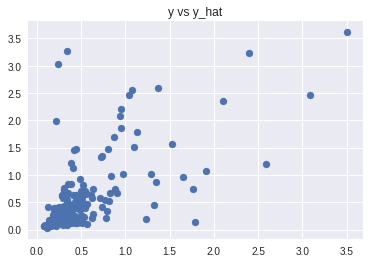

[0]	validation_0-rmse:0.456996
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.333322
[100]	validation_0-rmse:0.328523
[150]	validation_0-rmse:0.329486
Stopping. Best iteration:
[89]	validation_0-rmse:0.326767



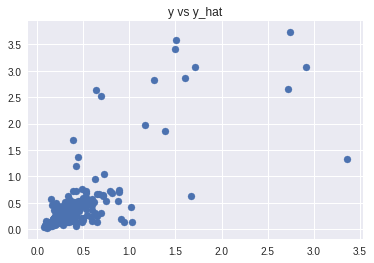

[0]	validation_0-rmse:0.45576
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.310595
[100]	validation_0-rmse:0.308627
[150]	validation_0-rmse:0.309149
Stopping. Best iteration:
[92]	validation_0-rmse:0.307835



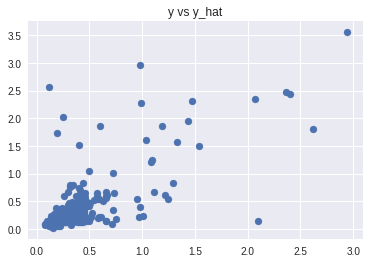

[0]	validation_0-rmse:0.365409
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.241162
[100]	validation_0-rmse:0.240238
[150]	validation_0-rmse:0.242487
Stopping. Best iteration:
[62]	validation_0-rmse:0.23971



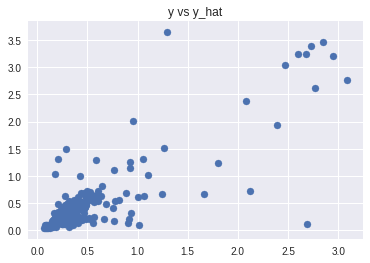

[0]	validation_0-rmse:0.492057
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.300716
[100]	validation_0-rmse:0.287951
[150]	validation_0-rmse:0.287859
[200]	validation_0-rmse:0.283278
[250]	validation_0-rmse:0.285176
[300]	validation_0-rmse:0.285502
Stopping. Best iteration:
[215]	validation_0-rmse:0.282384



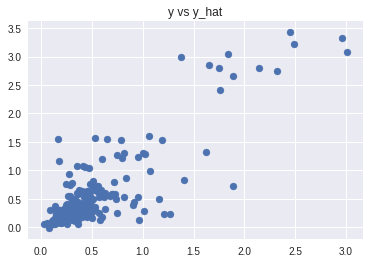

[0]	validation_0-rmse:0.500757
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.348936
[100]	validation_0-rmse:0.3473
[150]	validation_0-rmse:0.345499
[200]	validation_0-rmse:0.344361
[250]	validation_0-rmse:0.343423
[300]	validation_0-rmse:0.343548
Stopping. Best iteration:
[230]	validation_0-rmse:0.342659



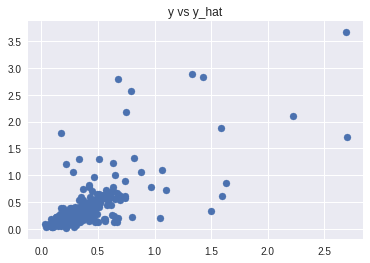

[0]	validation_0-rmse:0.489173
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.290958
[100]	validation_0-rmse:0.284332
[150]	validation_0-rmse:0.280884
[200]	validation_0-rmse:0.280355
[250]	validation_0-rmse:0.280793
Stopping. Best iteration:
[157]	validation_0-rmse:0.27975



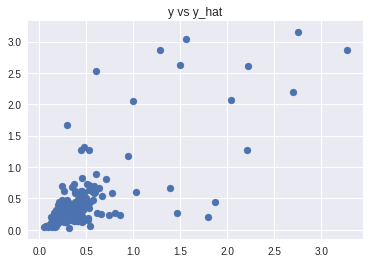

[0]	validation_0-rmse:0.437896
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.321169
[100]	validation_0-rmse:0.317286
[150]	validation_0-rmse:0.318981
[200]	validation_0-rmse:0.319526
Stopping. Best iteration:
[100]	validation_0-rmse:0.317286



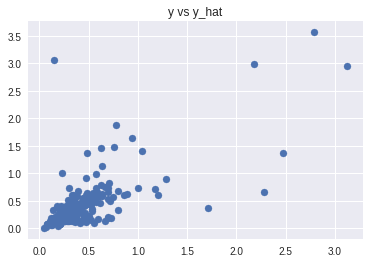

[0]	validation_0-rmse:0.507538
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.318748
[100]	validation_0-rmse:0.313305
[150]	validation_0-rmse:0.313322
[200]	validation_0-rmse:0.312461
Stopping. Best iteration:
[107]	validation_0-rmse:0.311641



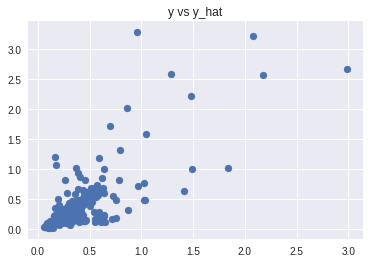

[0]	validation_0-rmse:0.474235
Will train until validation_0-rmse hasn't improved in 100 rounds.
[50]	validation_0-rmse:0.334171
[100]	validation_0-rmse:0.316258
[150]	validation_0-rmse:0.309081
[200]	validation_0-rmse:0.308663
[250]	validation_0-rmse:0.306818
[300]	validation_0-rmse:0.309698
Stopping. Best iteration:
[219]	validation_0-rmse:0.30645



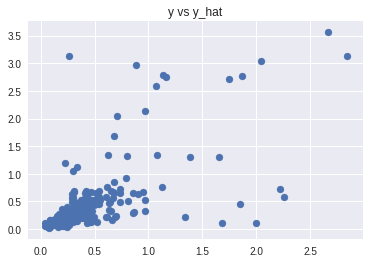

1190 correlated feature pairs left...
1148 correlated feature pairs left...
1108 correlated feature pairs left...
1070 correlated feature pairs left...
1028 correlated feature pairs left...
988 correlated feature pairs left...
950 correlated feature pairs left...
914 correlated feature pairs left...
880 correlated feature pairs left...
854 correlated feature pairs left...
830 correlated feature pairs left...
808 correlated feature pairs left...
788 correlated feature pairs left...
770 correlated feature pairs left...
754 correlated feature pairs left...
718 correlated feature pairs left...
684 correlated feature pairs left...
652 correlated feature pairs left...
622 correlated feature pairs left...
594 correlated feature pairs left...
568 correlated feature pairs left...
544 correlated feature pairs left...
522 correlated feature pairs left...
490 correlated feature pairs left...
476 correlated feature pairs left...
464 correlated feature pairs left...
454 correlated feature pairs left

KeyboardInterrupt: ignored

In [0]:
combinations_per_recipe = {
    3: [3, 1], 
    9: [8],
    15: [15, 1, 3, 7]
}

mode = 'turbidity'

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15, 9, 3]:
  for process_combination in combinations_per_recipe[recipe]:
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    
    X_train = train_features.drop('target', axis=1)
    y_train = np.log(labels.loc[X_train.index]['return_{}_mean'.format(mode)] + 1)
    
    X_test = test_features
    
    to_drop = remove_features(X_train, y_train)
    print(len(to_drop), to_drop)

    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)
    
    N_SPLITS = 10
    train_predictions = np.zeros((len(X_train),))
    test_predictions = np.zeros((len(X_test), N_SPLITS))
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
      X_cv_train = X_train.iloc[train_idx, :]
      X_cv_test = X_train.iloc[test_idx, :]
      y_cv_train = y_train.iloc[train_idx]
      y_cv_test = y_train.iloc[test_idx]
            
      train_idx = np.random.choice(X_cv_train.index, replace=False, size=int(0.9 * len(X_cv_train)))
      val_idx = list(set(X_cv_train.index) - set(train_idx))

      X_cv_val = X_cv_train.loc[val_idx, :]
      y_cv_val = y_cv_train.loc[val_idx]
      X_cv_train = X_cv_train.loc[train_idx, :]
      y_cv_train = y_cv_train.loc[train_idx]

        
      xgb = XGBRegressor(n_estimators=100000)
      xgb.fit(X_cv_train.values, y_cv_train.values, eval_set=[(X_cv_val.values, y_cv_val.values)], early_stopping_rounds=100, verbose=50)

      plt.figure()
      plt.scatter(x=xgb.predict(X_cv_test.values), y=y_cv_test)
      plt.title('y vs y_hat')
      plt.show()

      train_predictions[test_idx] = xgb.predict(X_cv_test.values)
      test_predictions[:, fold_ix] = xgb.predict(X_test.values)

    name = 'xgb'
    train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_return_{}_pred'.format(name, mode)])
    test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_return_{}_pred'.format(name, mode)])
    train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_{}_xgb_{}_{}.csv'.format(mode, recipe, process_combination))
    test_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_{}_xgb_{}_{}.csv'.format(mode, recipe, process_combination))

In [0]:
combinations_per_recipe = {
    3: [1, 3], 
    9: [8],
    15: [15, 3, 7, 1]
}

mode = 'turbidity'

prediction_df = None
import warnings; warnings.filterwarnings('ignore')
for recipe in [15, 3, 9]:
  for process_combination in combinations_per_recipe[recipe]:
    train_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/train_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    test_features = pd.read_csv('/content/drive/My Drive/Rinse Over Run/test_features_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    labels = pd.read_csv('/content/drive/My Drive/Rinse Over Run/final_phase_labels_{}_{}.csv'.format(recipe, process_combination), index_col=0)
    
    X_train = train_features.drop('target', axis=1)
    y_train = np.log(np.maximum(labels.loc[X_train.index]['return_{}_mean'.format(mode)], 0) + 1)
    
    X_test = test_features
    
    to_drop = remove_features(X_train, y_train)
    print(len(to_drop), to_drop)

    X_train = X_train.drop(to_drop, axis=1)
    X_test = X_test.drop(to_drop, axis=1)
    
    N_SPLITS = 10
    train_predictions = np.zeros((len(X_train),))
    test_predictions = np.zeros((len(X_test), N_SPLITS))
    kf = KFold(n_splits=N_SPLITS, shuffle=True)
    for fold_ix, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
      X_cv_train = X_train.iloc[train_idx, :]
      X_cv_test = X_train.iloc[test_idx, :]
      y_cv_train = y_train.iloc[train_idx]
      y_cv_test = y_train.iloc[test_idx]
            
      train_idx = np.random.choice(X_cv_train.index, replace=False, size=int(0.9 * len(X_cv_train)))
      val_idx = list(set(X_cv_train.index) - set(train_idx))

      X_cv_val = X_cv_train.loc[val_idx, :]
      y_cv_val = y_cv_train.loc[val_idx]
      X_cv_train = X_cv_train.loc[train_idx, :]
      y_cv_train = y_cv_train.loc[train_idx]

      lgbm = LGBMRegressor(n_estimators=10000)
      lgbm.fit(X_cv_train.values, y_cv_train.values, eval_set=(X_cv_val.values, y_cv_val.values), early_stopping_rounds=100, verbose=50)

      print('Fold #{} MAPE={}'.format(fold_ix + 1, custom_mape(np.exp(y_cv_test), np.exp(lgbm.predict(X_cv_test.values)))))

      train_predictions[test_idx] = np.minimum(np.max(y_cv_train), np.maximum(0, lgbm.predict(X_cv_test.values)))
      test_predictions[:, fold_ix] = np.minimum(np.max(y_cv_train), np.maximum(0, lgbm.predict(X_test.values)))


    name = 'lgbm'
    train_predictions_df = pd.DataFrame(train_predictions, index=X_train.index, columns=['{}_return_{}_pred'.format(name, mode)])
    test_predictions_df = pd.DataFrame(np.mean(test_predictions, axis=1), index=X_test.index, columns=['{}_return_{}_pred'.format(name, mode)])
    train_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/train_predictions_stack_{}_lgbm_{}_{}.csv'.format(mode, recipe, process_combination))
    test_predictions_df.to_csv('/content/drive/My Drive/Rinse Over Run/test_predictions_stack_{}_lgbm_{}_{}.csv'.format(mode, recipe, process_combination))    

958 correlated feature pairs left...
920 correlated feature pairs left...
878 correlated feature pairs left...
842 correlated feature pairs left...
808 correlated feature pairs left...
768 correlated feature pairs left...
736 correlated feature pairs left...
698 correlated feature pairs left...
668 correlated feature pairs left...
632 correlated feature pairs left...
630 correlated feature pairs left...
596 correlated feature pairs left...
568 correlated feature pairs left...
536 correlated feature pairs left...
506 correlated feature pairs left...
480 correlated feature pairs left...
456 correlated feature pairs left...
428 correlated feature pairs left...
402 correlated feature pairs left...
378 correlated feature pairs left...
356 correlated feature pairs left...
336 correlated feature pairs left...
314 correlated feature pairs left...
312 correlated feature pairs left...
292 correlated feature pairs left...
274 correlated feature pairs left...
256 correlated feature pairs left...
2